In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Markdown
from IPython.display import display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv("./data/TrainVal.csv")
data.sample(10)

,tweet,label,tweet_cleaned,tweet_len
6296,Drinking alcohol will prevent coronavirus! If ...,fake,drink alcohol prevent coronaviru increas alcoh...,42
5974,Italy's #coronavirus tracing app had 2.2 milli...,real,italy' coronaviru trace app 2.2 million downlo...,13
5678,@FaheemYounus Aren't hospitals doing the busin...,fake,hospit busi huge respect doc manag ... charg l...,46
4296,Facebook posts shared hundreds of times claim ...,fake,facebook post share hundr time claim us presid...,33
4073,Dad would rather get coronavirus than fist-bum...,fake,dad would rather get coronaviru fist-bump,9
117,India has lost over 50000 individuals to coron...,fake,india lost 5000 individu coronaviru till date ...,42
4736,NEWS! Lockdown and social distancing isn’t nec...,fake,news lockdown social distanc necessari realli ...,18
382,U.S. pediatric COVID-19 cases have jumped 90% ...,real,u pediatr covid 19 case jump 90 4 week,11
6975,COVID-19 is a vaccine that is 'activated' and ...,fake,covid 19 vaccin activ spread 5g,12
768,Meeting at the chariot held in #Kalabari distr...,fake,meet chariot held kalabari district karnataka ...,30


In [5]:
data.tweet.str.split().apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
90%        44.00000
95%        47.00000
max      1456.00000
Name: tweet, dtype: float64

In [6]:
data.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

In [7]:
trn, val, preproc = text.texts_from_df(
    data,
    text_column = "tweet",
    label_columns="label",
    maxlen=50,
    ngram_range=1,
    random_state=41,
    preprocess_mode="standard"
)

['fake', 'real']
      fake  real
5065   1.0   0.0
4761   0.0   1.0
2623   1.0   0.0
7367   1.0   0.0
3498   1.0   0.0
['fake', 'real']
      fake  real
1214   1.0   0.0
6002   1.0   0.0
3262   1.0   0.0
5198   0.0   1.0
2164   0.0   1.0
language: en
Word Counts: 22133
Nrows: 7704
7704 train sequences
train sequence lengths:
	mean : 30
	95percentile : 51
	99percentile : 58
x_train shape: (7704,50)
y_train shape: (7704, 2)
Is Multi-Label? False
856 test sequences
test sequence lengths:
	mean : 28
	95percentile : 49
	99percentile : 56
x_test shape: (856,50)
y_test shape: (856, 2)


In [8]:
model = text.text_classifier('nbsvm', trn , preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 50
building document-term matrix... this may take a few moments...
rows: 1-7704
computing log-count ratios...
done.


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 2)        40000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 1)        20000       ['input_1[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 2, 1)         0           ['embedding[0][0]',              
                                                                  'embedding_1[0][0]']        

In [10]:
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=64)

In [11]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
121/121 [==============================] - 0s 807us/step - loss: 0.6837 - accuracy: 0.5593
Epoch 2/1024
121/121 [==============================] - 0s 812us/step - loss: 0.6832 - accuracy: 0.5618
Epoch 3/1024
121/121 [==============================] - 0s 792us/step - loss: 0.6814 - accuracy: 0.5687
Epoch 4/1024
121/121 [==============================] - 0s 820us/step - loss: 0.6757 - accuracy: 0.5933
Epoch 5/1024
121/121 [==============================] - 0s 866us/step - loss: 0.6580 - accuracy: 0.6615
Epoch 6/1024
121/121 [==============================] - 0s 927us/step - loss: 0.6107 - accuracy: 0.7517
Epoch 7/1024
121/121 [==============================] - 0s 882us/step - loss: 0.5171 - accuracy: 0.8248
Epoch 8/1024
121/121 [==============================] - 0s 950us/step - loss: 0.3844 - accuracy: 0.8981
Epoch 9/1024
121/121 [==============================] - 0s 857us/step - loss: 0.2482 

Three possible suggestions for LR from plot:
	Longest valley (red): 6.61E-04
	Min numerical gradient (purple): 1.11E-03
	Min loss divided by 10 (omitted from plot): 4.43E-02


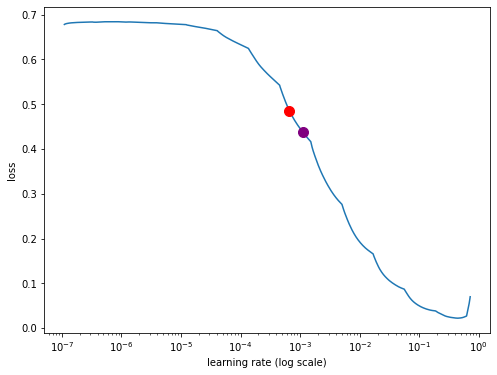

In [12]:
learner.lr_plot(suggest=True)

In [13]:
import gc
gc.collect()

14720

In [14]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(6.61E-04, 10)



begin training using onecycle policy with max lr of 0.000661...
Epoch 1/10
121/121 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.7040 - val_loss: 0.5577 - val_accuracy: 0.8037
Epoch 2/10
121/121 [==============================] - 0s 1ms/step - loss: 0.5006 - accuracy: 0.8300 - val_loss: 0.4554 - val_accuracy: 0.8540
Epoch 3/10
121/121 [==============================] - 0s 1ms/step - loss: 0.4042 - accuracy: 0.8851 - val_loss: 0.3786 - val_accuracy: 0.8937
Epoch 4/10
121/121 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.9242 - val_loss: 0.3212 - val_accuracy: 0.9206
Epoch 5/10
121/121 [==============================] - 0s 1ms/step - loss: 0.2753 - accuracy: 0.9403 - val_loss: 0.2788 - val_accuracy: 0.9299
Epoch 6/10
121/121 [==============================] - 0s 1ms/step - loss: 0.2348 - accuracy: 0.9499 - val_loss: 0.2515 - val_accuracy: 0.9322
Epoch 7/10
121/121 [==============================] - 0s 1ms/step - loss: 0.2095 -

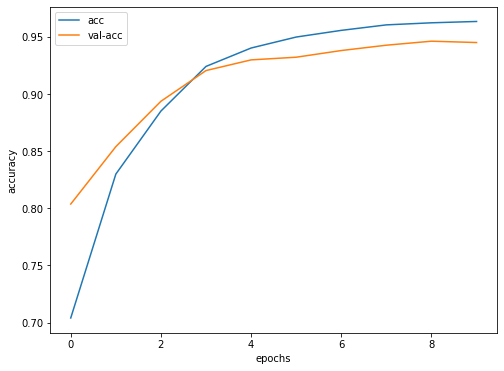

In [15]:
plt.plot(learner.history.history["accuracy"])
plt.plot(learner.history.history["val_accuracy"])
plt.legend(["acc", "val-acc"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

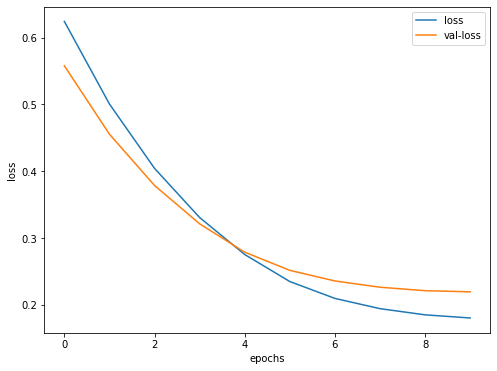

In [16]:
plt.plot(learner.history.history["loss"])
plt.plot(learner.history.history["val_loss"])
plt.legend(["loss", "val-loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [18]:
test_data = pd.read_csv("./data/TestLabel.csv", index_col=0)
test_data.sample(10)

,tweet,label
id,,
2034,Infamous Dubliner Janey Mac Tests Positive For...,fake
772,This year's list considered COVID-specific met...,real
1343,There have been no cases of infection in Beiji...,fake
1851,#IndiaFightsCorona: India's daily testing capa...,real
1061,Hundreds of doctors won’t start their residenc...,real
253,There is a Nipah Virus outbreak in India amids...,fake
277,Several social media users shared a picture of...,fake
752,Australia appears to be heading for its lowest...,real
1010,Together we have kept COVID out for 102 days -...,real


In [19]:
probs = predictor.predict_proba(test_data["tweet"].values)
probs[:5]

array([[0.01472371, 0.9852763 ],
       [0.8122849 , 0.18771516],
       [0.99606824, 0.00393174],
       [0.01207142, 0.98792857],
       [0.1140613 , 0.8859387 ]], dtype=float32)

In [24]:
y = (test_data.label == "real")
y.head()

id
1     True
2    False
3    False
4     True
5     True
Name: label, dtype: bool

In [21]:
import metrics as mmetrics

In [25]:
y = y.values.reshape((-1, 1))

perfs = mmetrics.get_performance_metrics(y, probs[:, 1:], ["nbsvm"])
perfs

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
nbsvm,1070,923,97,50,0.931,0.523,0.955,0.905,0.917,0.949,0.986,0.936,0.5
